In [ ]:
from sklearn.datasets import load_boston#一个标签是连续西变量的数据集
from sklearn.model_selection import cross_val_score#导入交叉验证模块
from sklearn.ensemble import RandomForestRegressor#导入随机森林回归系
 
boston = load_boston()
regressor = RandomForestRegressor(n_estimators=100,random_state=0)#实例化
cross_val_score(regressor, boston.data, boston.target, cv=10
               ,scoring = "neg_mean_squared_error"#如果不写scoring，回归评估默认是R平方
               )
%config InlineBackend.figure_format='svg'

### scoring可选择的参数

In [2]:
#sklearn当中的模型评估指标（打分）列表
import sklearn
sorted(sklearn.metrics.SCORERS.keys())#这些指标是scoring可选择的参数

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer#填补缺失值的类
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [4]:
dataset = load_boston()
dataset#是一个字典
dataset.target#查看数据标签
dataset.data#数据的特征矩阵
dataset.data.shape#数据的结构
#总共506*13=6578个数据
 
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]#506
n_features = X_full.shape[1]#13


In [5]:
#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失
 
rng = np.random.RandomState(0)#设置一个随机种子，方便观察
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))#3289
#np.floor向下取整，返回.0格式的浮点数

'''
所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可以利用索引来为数据中的任意3289个
位置赋空值
然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何
'''
missing_features = rng.randint(0,n_features,n_missing_samples)#randint（下限，上限，n）指在下限和上限之间取出n个整数
len(missing_features)#3289
missing_samples = rng.randint(0,n_samples,n_missing_samples)
len(missing_samples)#3289
'''
#missing_samples = rng.choice(n_samples,n_missing_samples,replace=False)
我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。
但如果我们需要的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中!
这里我们不采用np.random.choice,因为我们现在采样了3289个数据，远远超过我们的样本量506，使用np.random.choice会报错
'''
X_missing = X_full.copy()
y_missing = y_full.copy()
 
X_missing[missing_samples,missing_features] = np.nan
 
X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如pandas来得好用
X_missing.head()

#并没有对y_missing进行缺失值填补，原因是有监督学习，不能缺标签啊



,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33


### 使用均值进行填补

In [ ]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')#实例化
X_missing_mean = imp_mean.fit_transform(X_missing)#特殊的接口fit_transform = 训练fit + 导出predict

### 使用0进行填补

In [ ]:
#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)#constant指的是常数
X_missing_0 = imp_0.fit_transform(X_missing)

In [17]:
#pd.DataFrame(X_missing_mean).isnull()#但是数据量大的时候还是看不全
#布尔值False = 0， True = 1 
pd.DataFrame(X_missing_mean).isnull().sum()#如果求和为0可以彻底确认是否有NaN

array([[3.62757895e+00, 1.80000000e+01, 1.11634641e+01, ...,
        1.85211921e+01, 3.52741952e+02, 4.98000000e+00],
       [2.73100000e-02, 0.00000000e+00, 1.11634641e+01, ...,
        1.85211921e+01, 3.96900000e+02, 9.14000000e+00],
       [2.72900000e-02, 1.07229508e+01, 7.07000000e+00, ...,
        1.85211921e+01, 3.52741952e+02, 1.29917666e+01],
       ...,
       [3.62757895e+00, 1.07229508e+01, 1.19300000e+01, ...,
        2.10000000e+01, 3.52741952e+02, 5.64000000e+00],
       [1.09590000e-01, 0.00000000e+00, 1.19300000e+01, ...,
        2.10000000e+01, 3.93450000e+02, 6.48000000e+00],
       [4.74100000e-02, 0.00000000e+00, 1.19300000e+01, ...,
        1.85211921e+01, 3.96900000e+02, 7.88000000e+00]])

In [7]:
X_missing_reg = X_missing.copy()

#找出数据集中，缺失值从小到大排列的特征们的顺序，并且有了这些的索引
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values#np.argsort()返回的是从小到大排序的顺序所对应的索引
 
for i in sortindex:
    
    #构建我们的新特征矩阵（没有被选中去填充的特征 + 原始的标签）和新标签（被选中去填充的特征）
    df = X_missing_reg
    fillc = df.iloc[:,i]#新标签
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)#新特征矩阵
    
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)
                        
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]# Ytrain是被选中要填充的特征中（现在是我们的标签），存在的那些值：非空值
    Ytest = fillc[fillc.isnull()]#Ytest 是被选中要填充的特征中（现在是我们的标签），不存在的那些值：空值。注意我们需要的不是Ytest的值，需要的是Ytest所带的索引
    Xtrain = df_0[Ytrain.index,:]#在新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
    Xtest = df_0[Ytest.index,:]#在新特征矩阵上，被选出来的要填充的特征的空值所对应的记录
    
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)#实例化
    rfc = rfc.fit(Xtrain, Ytrain)#导入训练集进行训练
    Ypredict = rfc.predict(Xtest)#用predict接口将Xtest导入，得到我们的预测结果（回归结果），就是我们要用来填补空值的这些值
    
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg.loc[X_missing_reg.iloc[:,i].isnull(),i] = Ypredict

#检验是否有空值
X_missing_reg.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [8]:
#对所有数据进行建模，取得MSE结果
 
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg]
 
mse = []
std = []
for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)#实例化
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(scores * -1)

In [9]:
[*zip(['Full data','Zero Imputation','Mean Imputation','Regressor Imputation'],mse)]

[('Full data', 21.571667100368845),
 ('Zero Imputation', 40.848037216676374),
 ('Mean Imputation', 49.626793201980185),
 ('Regressor Imputation', 19.567560044205)]

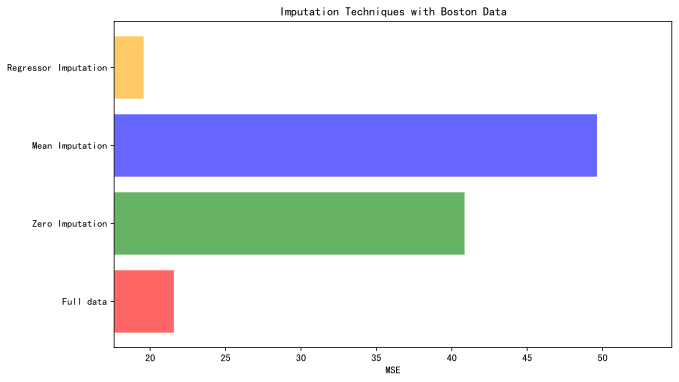

In [13]:
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']
 
plt.figure(figsize=(10, 6))#画出画布
ax = plt.subplot(111)#添加子图
for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')#bar为条形图，barh为横向条形图，alpha表示条的粗度
ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9,
             right=np.max(mse) * 1.1)#设置x轴取值范围
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
ax.set_yticklabels(x_labels)
plt.show()